In [1]:
import numpy as np
import stoclust as sc
from stoclust.Group import Group
from stoclust.Aggregation import Aggregation
from stoclust.Hierarchy import Hierarchy

import plotly.offline as py
import plotly.graph_objs as go

In [2]:
h = Hierarchy(Group(np.array(['A','B','C','D'])),
          Group(np.array(['A','B','C','D',4,5,6])),
          {4:(1,np.array([0,1])),
           5:(2,np.array([2,3])),
           6:(3,np.array([4,5]))})

In [3]:
A1 = h.at_scale(2)
A2 = h.at_scale(3)
A1*A2

TypeError: unhashable type: 'numpy.ndarray'

In [8]:
labels = np.arange(12).reshape([3,2,2]) - np.array([0,4,8])[:,None,None]
np.unique(labels,axis=0)

array([[[0, 1],
        [2, 3]]])

In [ ]:
tuple()

In [6]:
h.set_scales(mu)

Aggregation({'4': array(['A', 'B'], dtype='<U1'), '5': array(['C', 'D'], dtype='<U1')})

In [12]:
from functools import reduce
reduce(lambda x,y:x+y,[g1,g2],Group(np.array([])))

Group(['E', 'D', 'A', 'F', 'C', 'B'])

In [3]:
h.at_scale(1)

Aggregation({'4': array(['A', 'B'], dtype='<U1'), 'C': array(['C'], dtype='<U1'), 'D': array(['D'], dtype='<U1')})

In [18]:
h.clusters.elements[np.array([1,2])]

TypeError: only integer scalar arrays can be converted to a scalar index

In [21]:
a = np.array([0,1,2,3,4,5])
a[np.array([1,2])]

array([1, 2])

# Overview

`stoclust` is a package of modularized methods for stochastic clustering techniques. By modular, I mean that there are few methods in this package which act as a single pipeline for clustering a dataset–––rather, the methods each form a unit of what might be a larger clustering routine.

Currently, the core of the package is in the three classes `Group`, `Aggregation` and `Hierarchy` as well as the `stoclust.clustering` submodule, which contains functions that each perform some irreducible clustering technique. 

The three classes each describe an essential idea for generalized clustering techniques:

1. `Group`: This class is something between a Numpy array and a set. It is assumed that there are no duplicate elements in a `Group`; however, the elements are indexed. `Group` contains special features such as the `in_family` attribute which allows one to tie a subset `Group` to its containing `Group` by cross-referencing indices.

2. `Aggregation`: This class is the most basic form of clustering. It ties together a complete set of non-intersecting sub`Group`s for some `Group` of items (using the `in_family` attribute), and classifies these clusters as their own `Group` under the attribute `Aggregation.labels`. This class can also be used to generate block matrices describing the cluster, with rows and columns indexed consistently with the original `Group` of items.

3. `Hierarchy`: This class describes a hierarchical clustering scheme, containing information about multiple layers of nested `Group`s at once. As with `Aggregation`, this class is oriented around a `Group` of items (`Hierarchy.items`) as well as a `Group` of labels (`Hierarchy.labels`) corresponding to the unique clusters. The attribute `Hierarchy.scales` and `Hierarchy.children` are dictionaries which for each cluster label provide a *scale* (any user-provided ranking quantity that grows larger as clusters become more coarse-grained) and `Group` containing the labels of immediate sub-clusters, respectively. Users can then utilize the methods `Hierarchy.at_scale` (which provides an `Aggregation` corresponding to the largest non-intersecting partition of clusters whose scales do not exceed a given quantity), `Hierarchy.cluster_groups` (which provides a dictionary assigning to each cluster label the full `Group` of items under that cluster's jurisdiction), and more.

`Aggregation`s and `Hierarchy`s are primarily generated by the following methods from `stoclust.clustering`:

1. `split_by_vals`: Given a vector (one-dimensional array), generates an `Aggregation` of its indices based on provided cutoff values.
2. `split_by_gaps`: Given a vector, generates an `Aggregation` of its indices based on the lagest $N$ gaps between its sorted values, whiere $N$ is user-provided.
3. `split_by_ratios`: Given a vector, generates an `Aggregation` of its indices based on target ratios (e.g., splitting the vector into the top 5% values and the lowest 95% values).
4. `shi_malik`: Given a square weight matrix $W$ describing similarity between pairs of vectors, forms an `Aggregation` of the row/column indices via a spectral clustering technique on the Markov matrix $WD^{-1}$, where $D$ is a diagonal matrix whose elements are row sums.
5. `meyer_wessell`: Given a bistochastic weight matrix $W$, forms an `Aggregation` of the row/column indices based on the dynamics $W^t x$ of iterated multiplication by $W$ of some random initial vector $x$.
6. `fushing_mcassey`: Given a square weight matrix $W$, forms an `Aggregation` of the row/column indices based on the path of a regulated random walk using the Markov matrix $WD^{-1}$. 
7. `hier_from_blocks`: Given a sequence of block matrices, each more coarse-grained than the last, constructs the corresponding `Hierarchy`.

Few of these clustering methods are meant to be used on their own, and as we will explore have their own strengths and pitfalls, but each play a role in building larger pipelines of sound and robust clustering techniques.

An essential element in these pipelines is the *ensemble*. An ensemble is a collection of parallel data structures describing a system which, through comparison of the parallel features, can provide more robust inference than any of the data structures alone. The two primary forms of ensemble intended to be used with this package are:

1. *Randomized ensembles*: These ensembles arise when some randomization step occurs during a clustering technique (as is the case with `meyer_wessell` and `fushing_mcassey`). With such methods, one may choose to use the technique once (*single-shot*) and roll the dice, or, for more robust results, one can perform the technique multiple times and compare the results–––a randomized ensemble. This second option is allowed by the function `stoclust.ensemble.random_clustering`, which intakes a weight matrix and any method function which the user wishes to sample results from, and returns a collection of block matrices corresponding to the various clustering results.

2. *Parameterized ensembles*: These ensembles arise when one has many possible given inputs to a clustering technique. For instance, one way to build a hierarchical clustering scheme is through parameterization of the weights. Suppose that for a set of items we have a distance matrix $d_{ij}$. We could define the parameterized weights $W_{ij}(T) = \exp{-d_{ij}/T}$, which for small values of $T$ would result in a very sparse matrix describing isolated items, and for large $T$ would describe a dense network of uniformly connected items. The intermediate values allow for studying how clusters form and break apart between these extremes. Using the function `stoclust.ensemble.given_ensemble' one can generate a sequence of block matrices from each provided weight matrix. It is recommended to then apply the `stoclust.ensemble.smooth_blocks` function, which enforces the consistency required to construct a `Hierarchy` from the parameterization.

`stoclust` also contains a `utils` submodule, as well as several auxiliary submodules for generating examples, calculating distance and similarity matrices, and visualizing results, which will be featured in this documentation.

# Vector clustering

In this section we'll show the three methods for clustering vector indices: by gaps, value, and quantile.

## Gap clustering

Given a vector $v_i$ with indices $i\in I$, this approach clusters the set $I$ by first sorting the vector's values, determining the largest $k$ gaps, and creating 

In [2]:
vec = np.random.rand(50)
agg = sc.clustering.split_by_gaps(vec,num_gaps=3)

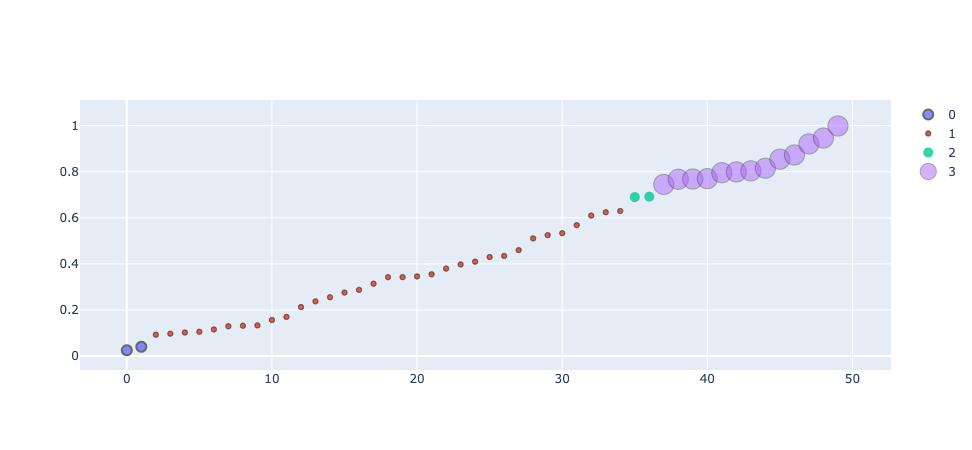

In [3]:
ranked_inds = np.empty_like(vec)
ranked_inds[np.argsort(vec)] = np.arange(len(vec))
group_inds = [g.in_family for k,g in agg]
vecs = np.stack([np.vstack([ranked_inds,vec])]*agg.size)

fig = sc.visualization.scatter2D(vecs,show_items=group_inds,names=agg.labels,
                           size=[10,5,10,20],line_width=[2,1,0,1],opacity=[0.8,1,0.8,0.5])
py.iplot(fig)

## Value clustering

In [5]:
vec = np.random.rand(50)
agg = sc.clustering.split_by_vals(vec,cuts=[0.25,0.6])

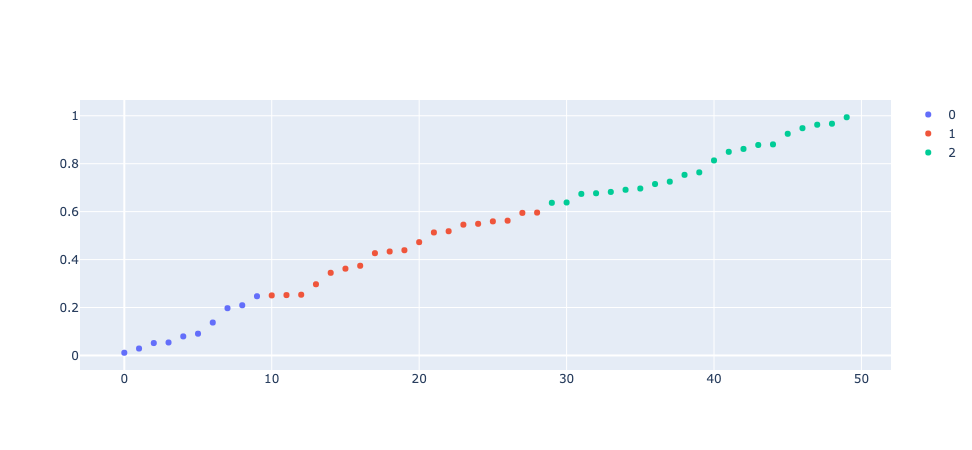

In [6]:
ranked_inds = np.empty_like(vec)
ranked_inds[np.argsort(vec)] = np.arange(len(vec))
group_inds = [g.in_family for k,g in agg]
vecs = np.stack([np.vstack([ranked_inds,vec])]*agg.size)

sc.visualization.scatter2D(vecs,show_items=group_inds,names=agg.labels)

## Quantile clustering

In [22]:
vec = np.random.rand(50)**3
agg = sc.clustering.split_by_ratio(vec,ratios=np.array([0.9,0.1]))
agg

Aggregation({0: Group([16, 19, 33, 46, 49]), 1: Group([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48])})

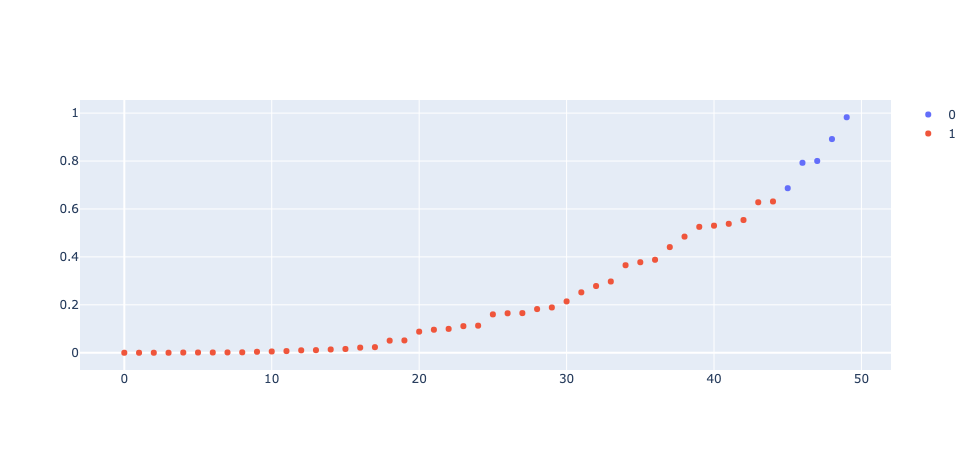

In [23]:
ranked_inds = np.empty_like(vec)
ranked_inds[np.argsort(vec)] = np.arange(len(vec))
group_inds = [g.in_family for k,g in agg]
vecs = np.stack([np.vstack([ranked_inds,vec])]*agg.size)

sc.visualization.scatter2D(vecs,show_items=group_inds,names=agg.labels)

# 2D Example: Two Moons

In [2]:
samples = sc.examples.two_moons(num_samples=300)
samples_stacked = np.moveaxis(np.stack([samples,samples]),[1,2],[2,1])
show_inds = [np.arange(150),np.arange(150,300)]

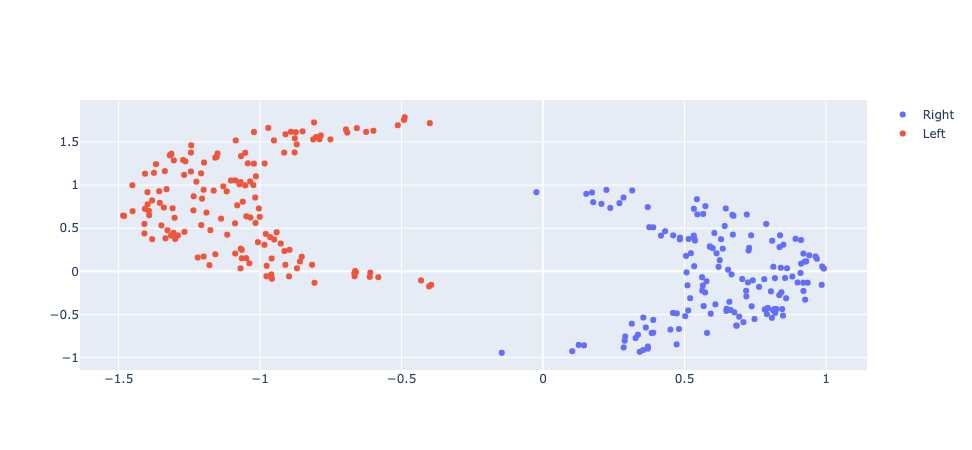

In [3]:
sc.visualization.scatter2D(samples_stacked,names=['Right','Left'],show_items=show_inds)

## Spectral clustering (Shi & Malik)

In [4]:
dist = sc.distance.euclid(samples)
scales = np.arange(0.005,0.7,0.005)
weights = np.exp(-dist[None,:,:]/scales[:,None,None])

In [5]:
bmats = sc.ensemble.given_ensemble(weights,clustering_method=sc.clustering.shi_malik,show_progress=True)
smooth = sc.ensemble.smooth_block(bmats,window=10)

100%|██████████| 139/139 [00:11<00:00, 12.52it/s]


In [6]:
C = sc.clustering.hier_from_blocks(smooth,scales=scales)

In [7]:
C._children

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [],
 29: [],
 30: [],
 31: [],
 32: [],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: [],
 40: [],
 41: [],
 42: [],
 43: [],
 44: [],
 45: [],
 46: [],
 47: [],
 48: [],
 49: [],
 50: [],
 51: [],
 52: [],
 53: [],
 54: [],
 55: [],
 56: [],
 57: [],
 58: [],
 59: [],
 60: [],
 61: [],
 62: [],
 63: [],
 64: [],
 65: [],
 66: [],
 67: [],
 68: [],
 69: [],
 70: [],
 71: [],
 72: [],
 73: [],
 74: [],
 75: [],
 76: [],
 77: [],
 78: [],
 79: [],
 80: [],
 81: [],
 82: [],
 83: [],
 84: [],
 85: [],
 86: [],
 87: [],
 88: [],
 89: [],
 90: [],
 91: [],
 92: [],
 93: [],
 94: [],
 95: [],
 96: [],
 97: [],
 98: [],
 99: [],
 100: [],
 101: [],
 102: [],
 103: [],
 104: [],
 105: [],
 106: [],
 107: [],
 108: [],
 109: [],
 110: [],


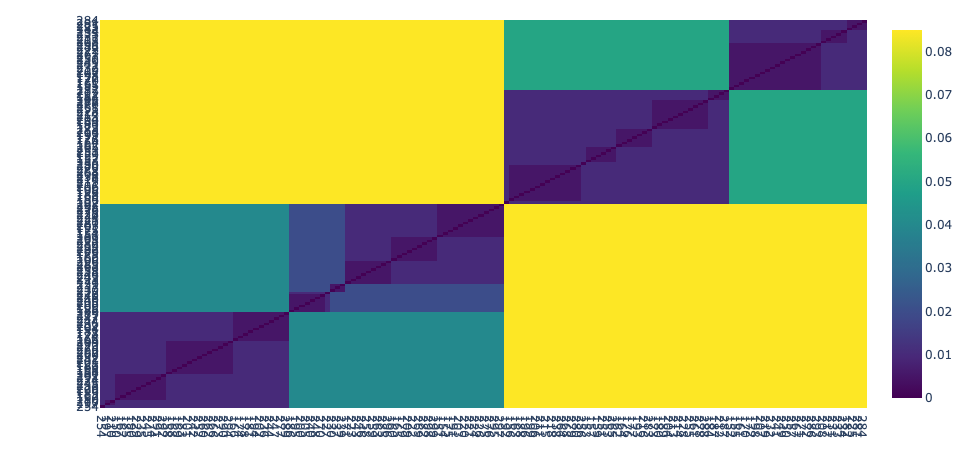

In [9]:
sc.visualization.heatmap(C.get_ultrametric(),
                         show_x=C.cluster_groups()[C.clusters.size-1],
                         show_y=C.cluster_groups()[C.clusters.size-1],
                         x_labels = C.items, y_labels = C.items)

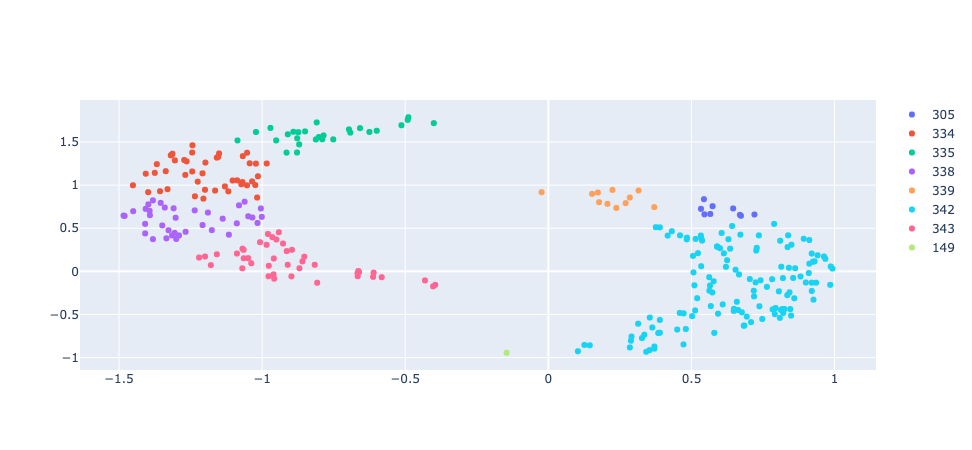

In [12]:
agg = C.at_scale(0.03)
show_inds = [g.in_superset for k,g in agg]
samples_stacked = np.moveaxis(np.stack([samples]*agg.clusters.size),[1,2],[2,1])
sc.visualization.scatter2D(samples_stacked,names=agg.clusters,show_items=show_inds)

## Dynamical clustering (Meyer & Wessell)

In [ ]:
from tqdm import tqdm
scales = np.arange(0.05,5,0.05)
weights = np.exp(-dist[None,:,:]/scales[:,None,None])
bi_mats = np.stack([sc.utils.sinkhorn_knopp(weights[j],rescalings=False) for j in tqdm(range(weights.shape[0]))])

clustering_method = lambda W:sc.clustering.meyer_wessell(sc.similarity.from_random_clustering(W,clustering_method=sc.clustering.meyer_wessell,ensemble_size=50))
bmats = sc.ensemble.given_ensemble(bi_mats,clustering_method=clustering_method,show_progress=True)
smooth = sc.ensemble.smooth_block(bmats)

In [ ]:
C = sc.clustering.hier_from_blocks(smooth,scales=scales)
sc.visualization.heatmap(C.get_ultrametric(),
                         show_x=C.cluster_groups()[C.clusters.size-1],
                         show_y=C.cluster_groups()[C.clusters.size-1],
                         x_labels = C.items, y_labels = C.items)

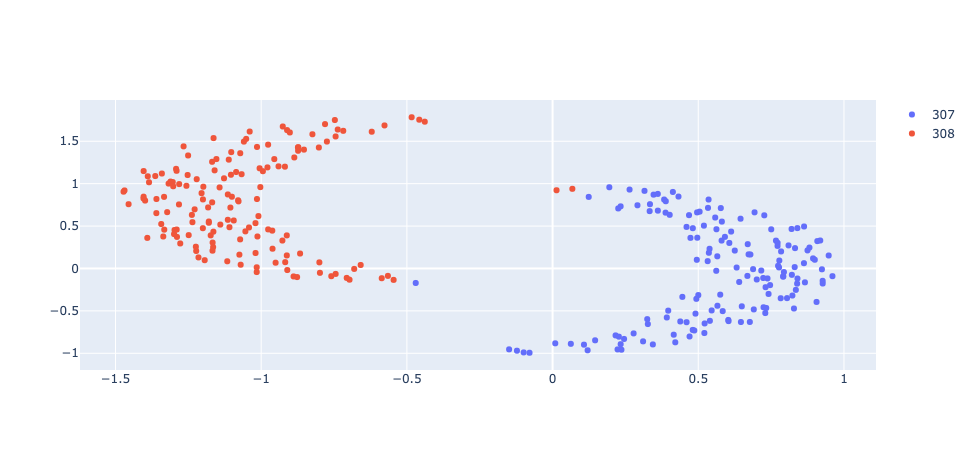

In [19]:
agg = C.at_scale(2.1)
show_inds = [g.in_family for k,g in agg]
samples_stacked = np.moveaxis(np.stack([samples]*agg.size),[1,2],[2,1])
sc.visualization.scatter2D(samples_stacked,names=agg.labels,show_items=show_inds)

## Data Cloud Geometry (Fushing & McAssey)

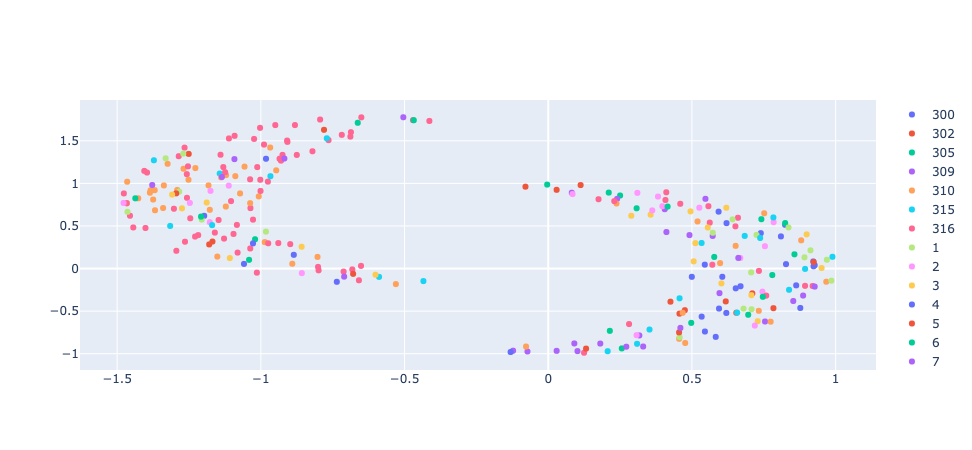

In [7]:
agg = sc.clustering.fushing_mcassey(weights[40])
show_inds = [g.in_superset for k,g in agg]
samples_stacked = np.moveaxis(np.stack([samples]*agg.clusters.size),[1,2],[2,1])
sc.visualization.scatter2D(samples_stacked,names=agg.clusters,show_items=show_inds)

In [21]:
agg.labels

Group([300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498

In [20]:
scales = np.arange(0.01,1,0.01)
weights = np.exp(-dist[None,:,:]/scales[:,None,None])

clustering_method = lambda W:sc.clustering.shi_malik(sc.similarity.from_random_clustering(W,clustering_method=sc.clustering.fushing_mcassey,ensemble_size=50))
bmats = sc.ensemble.given_ensemble(weights,clustering_method=clustering_method,show_progress=True)
smooth = sc.ensemble.smooth_block(bmats,window=5)

100%|██████████| 99/99 [1:28:41<00:00, 53.75s/it]


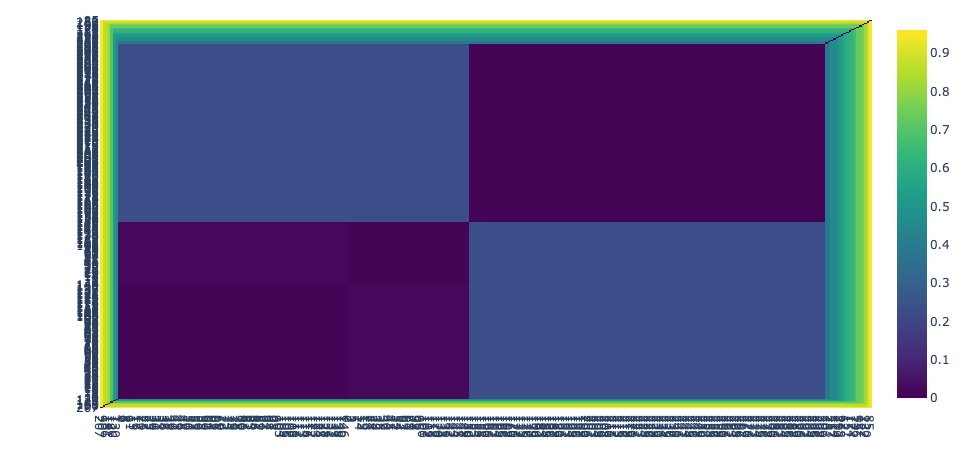

In [21]:
C = sc.clustering.hier_from_blocks(smooth,scales=scales)
sc.visualization.heatmap(C.get_ultrametric(),
                         show_x=C.cluster_groups()[C.num_clusters-1],
                         show_y=C.cluster_groups()[C.num_clusters-1],
                         x_labels = C.items, y_labels = C.items)

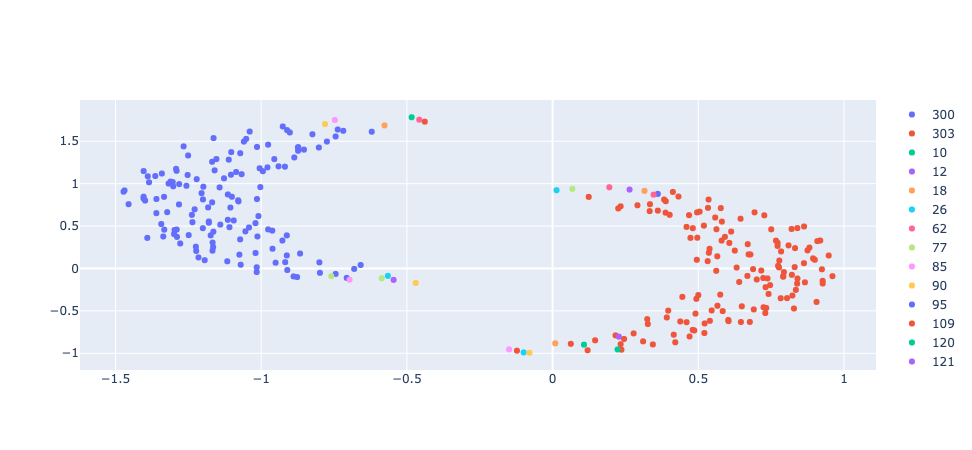

In [22]:
agg = C.at_scale(0.2)
show_inds = [g.in_family for k,g in agg]
samples_stacked = np.moveaxis(np.stack([samples]*agg.size),[1,2],[2,1])
sc.visualization.scatter2D(samples_stacked,names=agg.labels,show_items=show_inds)